In [ ]:
import pandas as pd
import numpy as np
from prophet import Prophet
from prophet.plot import plot_plotly, plot_components_plotly
from sklearn.metrics import mean_absolute_percentage_error as mape

import matplotlib.pyplot as plt
%matplotlib inline

In [ ]:
data = pd.read_csv('/content/11. Number of domestic air travel passengers.csv', parse_dates=True, index_col='Date')
data.index.freq = 'MS'

data.head()

,Number of domestic air passengers
Date,
2003-01-01,43032450
2003-02-01,41166780
2003-03-01,49992700
2003-04-01,47033260
2003-05-01,49152352


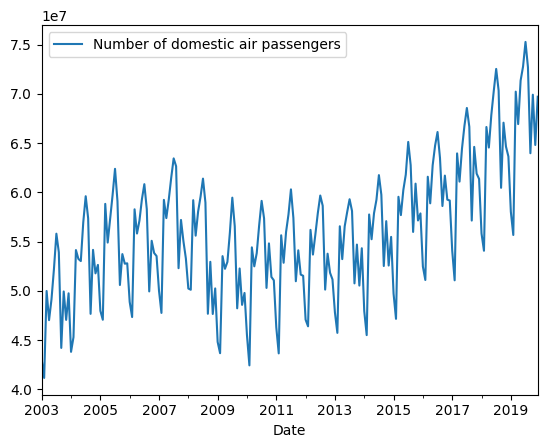

In [ ]:
data.plot()

plt.show()

Так как тренд меняется на протяжении временного ряда, попробуем выявить примерные точки изменения тренда

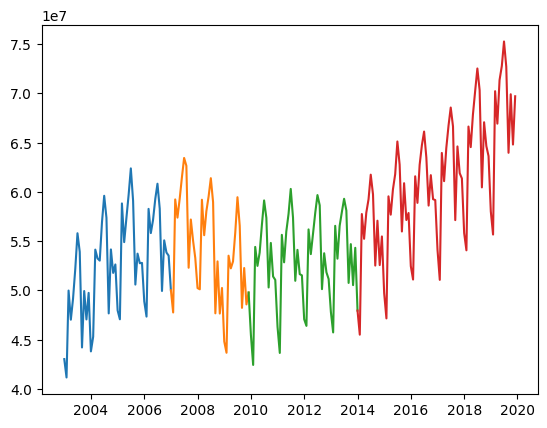

In [ ]:
plt.plot(data.loc[:'2007-01-01', :])
plt.plot(data.loc['2007-01-01':'2009-12-01', :])
plt.plot(data.loc['2009-12-01':'2014-01-01', :])
plt.plot(data.loc['2014-01-01':, :])

plt.show()

Подготовим данные для обучения модели

In [ ]:
data_prophet = data[['Number of domestic air passengers']]
data_prophet = data_prophet.reset_index()
data_prophet.columns = ['ds', 'y']
data_prophet['cap'] = 1e8 # Ограничение сверху

data_prophet.head()

,ds,y,cap
0,2003-01-01,43032450,100000000.0
1,2003-02-01,41166780,100000000.0
2,2003-03-01,49992700,100000000.0
3,2003-04-01,47033260,100000000.0
4,2003-05-01,49152352,100000000.0


Создадим модель, указав в ней ограничение на рост (```growth = 'logistic'```), явные точки изменения тренда (```changepoints```), коэффициенты на учет этих точек сочленения и праздников, а также предварительно удалим всю сезонность

In [ ]:
model = Prophet(growth = 'logistic', changepoints=['2007-01-01', '2009-12-01', '2014-01-01'], changepoint_prior_scale=0.7,
                weekly_seasonality=False, daily_seasonality=False, yearly_seasonality=False, holidays_prior_scale = 0.05)

Добавим годовую сезонность (из предыдущих заданий сезонность = 12 месяцев -> 365.25 дней) и учтем праздничные дни в Штатах

In [ ]:
model.add_seasonality(name='yearly1', period=365.25, fourier_order=10)

In [ ]:
model.add_country_holidays(country_name='US')

Обучим модель на исходных данных и сделаем прогноз на три года

In [ ]:
model.fit(data_prophet)

DEBUG:cmdstanpy:input tempfile: /tmp/tmpo5z7jgvw/9apvdkn1.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpo5z7jgvw/ltsd0rln.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=82787', 'data', 'file=/tmp/tmpo5z7jgvw/9apvdkn1.json', 'init=/tmp/tmpo5z7jgvw/ltsd0rln.json', 'output', 'file=/tmp/tmpo5z7jgvw/prophet_modelx5kxol3u/prophet_model-20240430113243.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
11:32:43 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
11:32:43 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


In [ ]:
future = model.make_future_dataframe(periods=36, freq='MS')
future['cap'] = 1e8

In [ ]:
forecast = model.predict(future)

Отрисуем интерактивный график полученной модели

In [ ]:
plot_plotly(model, forecast)

Посчитаем MAPE на всей исходной выборке

In [ ]:
print('MAPE аппроксимации -', mape(data.values, forecast.yhat[:-36]))

MAPE аппроксимации - 0.016817063796334297


Отрисуем график исходных данных и аппроксимации моделью (вместе с прогнозом)

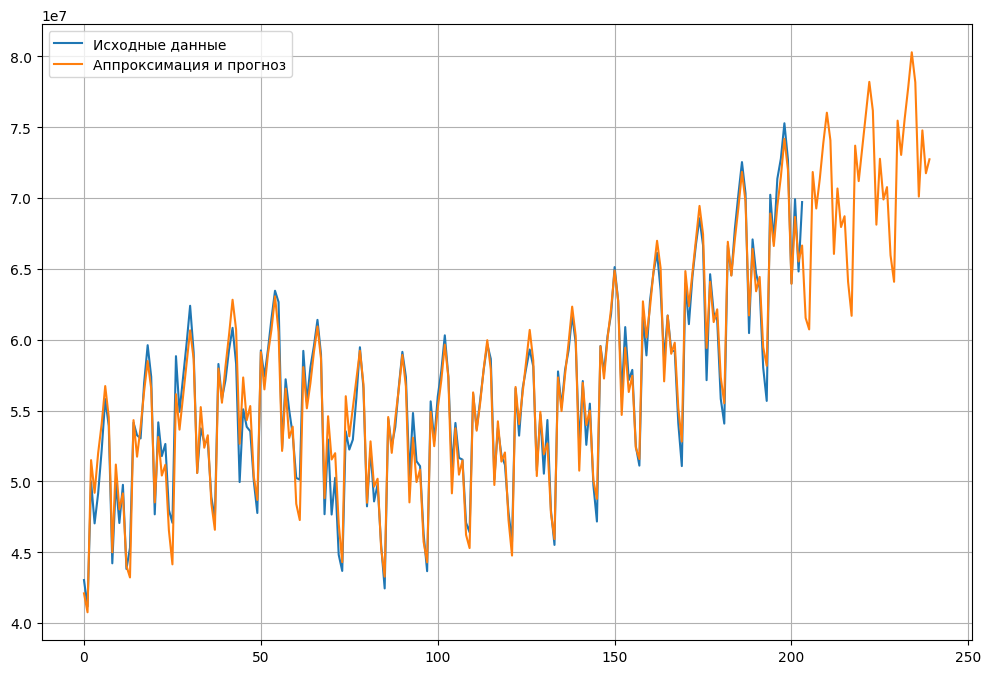

In [ ]:
plt.figure(figsize=(12,8))

plt.plot(data.values, label='Исходные данные')
plt.plot(forecast.yhat, label='Аппроксимация и прогноз')

plt.grid()
plt.legend()
plt.show()